In [94]:
from kan import *
from kan.utils import batch_jacobian, batch_hessian

torch.use_deterministic_algorithms(True)
torch.set_default_dtype(torch.float64)

seed = 0
torch.manual_seed(seed)

#example = 'harmonic_oscillator'
#example = 'single_pendulum'
example = 'relativistic_mass'

# three examples: harmonic oscillator, single pendulum, double pendulum

# dimension of q
# Lagrangian: (q, qd) -> (qdd)

if example == 'harmonic_oscillator':
    n_sample = 1000
    # harmonic oscillator
    d = 1
    q = torch.rand(size=(n_sample,1)) * 4 - 2
    qd = torch.rand(size=(n_sample,1)) * 4 - 2
    qdd = - q
    x = torch.cat([q, qd], dim=1)
    
if example == 'single_pendulum':
    n_sample = 1000
    # harmonic oscillator
    d = 1
    q = torch.rand(size=(n_sample,1)) * 4 - 2
    qd = torch.rand(size=(n_sample,1)) * 4 - 2
    qdd = - torch.sin(q)
    x = torch.cat([q, qd], dim=1)
    
if example == 'relativistic_mass':
    n_sample = 10000
    # harmonic oscillator
    d = 1
    q = torch.rand(size=(n_sample,1)) * 4 - 2
    #qd = torch.rand(size=(n_sample,1)) * 1.998 - 0.999
    #qd = 0.95 + torch.rand(size=(n_sample,1)) * 0.05
    qd = torch.rand(size=(n_sample,1)) * 2 - 1
    qdd = (1 - qd**2)**(3/2)
    x = torch.cat([q, qd], dim=1)



In [95]:
from kan.compiler import kanpiler
from sympy import *

input_variables = symbol_x, symbol_vx = symbols('x v_x')
expr = symbol_vx ** 2
model = kanpiler(input_variables, expr, grid=20)

saving model version 0.1


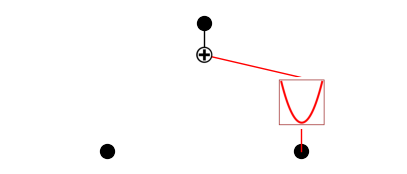

In [96]:
model.get_act(x)
model.plot()

saving model version 0.2


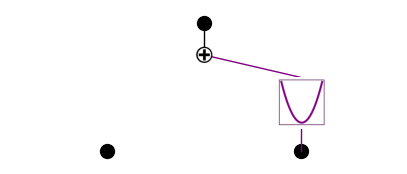

In [97]:
model.perturb(mode='best', mag=0.1)
model.get_act(x)
model.plot()

In [98]:
from kan import *
from kan.utils import batch_jacobian, create_dataset_from_data
import numpy as np

torch.use_deterministic_algorithms(True)

def closure():
    
    global loss
    optimizer.zero_grad()
    
    jacobian = batch_jacobian(model, x, create_graph=True)
    hessian = batch_hessian(model, x, create_graph=True)
    Lqdqd = hessian[:,d:,d:]
    Lq = jacobian[:,:d]
    Lqqd = hessian[:,d:,:d]

    Lqqd_qd_prod = torch.einsum('ijk,ik->ij', Lqqd, qd)

    qdd_pred = torch.einsum('ijk,ik->ij', torch.linalg.inv(Lqdqd), Lq - Lqqd_qd_prod)
    loss = torch.mean((qdd - qdd_pred)**2)

    loss.backward()
    return loss

steps = 20
log = 1
optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
#optimizer = torch.optim.Adam(params, lr=1e-2)
pbar = tqdm(range(steps), desc='description', ncols=100)


for _ in pbar:
    
    # update grid
    if _ < 5 and _ % 20 == 0:
        model.update_grid(x)
            
    optimizer.step(closure)
    
    if _ % log == 0:
        pbar.set_description("| loss: %.2e |" % loss.cpu().detach().numpy())
        
        

| loss: 5.03e-05 |: 100%|███████████████████████████████████████████| 20/20 [02:59<00:00,  8.99s/it]


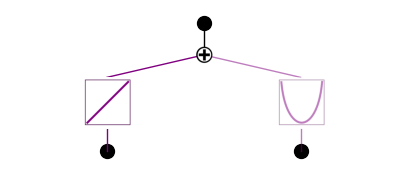

In [99]:
model.plot()

In [100]:
model.auto_symbolic()

KeyboardInterrupt: 

In [80]:
model.unfix_symbolic(0,0,0)
model.suggest_symbolic(0,0,0)

saving model version 0.5
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000000 -16.565706           1                1   -2.513141
1      cos    1.000000 -16.599499           2                2   -1.719900
2      sin    1.000000 -16.599499           2                2   -1.719900
3      exp    0.999997 -16.268112           2                2   -1.653622
4    x^0.5    0.999977 -14.896568           2                2   -1.379314


('x',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  1,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9999996907837526,
 1)

In [47]:
model.unfix_symbolic(0,1,0)
model.suggest_symbolic(0,1,0)

saving model version 0.4
  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1      cos    0.969503 -5.034727           2                2    0.593055
2      x^2    0.969092 -5.015413           2                2    0.596917
3      sin    0.965249 -4.846400           2                2    0.630720
4        x    0.000392 -0.000551           1                1    0.799890


('0',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  0,
  <function kan.utils.<lambda>(x, y_th)>),
 0.0,
 0)

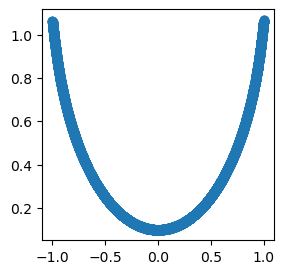

In [101]:
x, y = model.get_fun(0,1,0)

In [102]:
from kan.utils import create_dataset_from_data

dataset2 = create_dataset_from_data(x[:,None], y[:,None])
model2 = KAN(width=[1,1,1])
model2.fix_symbolic(0,0,0,'x^2',fit_params_bool=False)

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


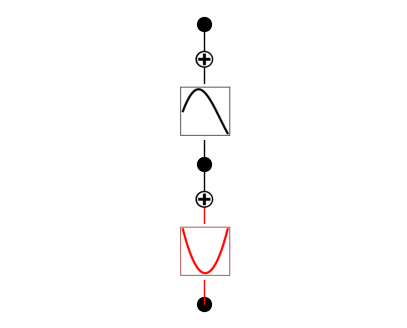

In [103]:
model2.get_act(dataset2)
model2.plot()

In [104]:
model2.fit(dataset2, steps=50);

| train_loss: 3.77e-04 | test_loss: 3.76e-04 | reg: 3.35e+00 | : 100%|█| 50/50 [00:46<00:00,  1.07it

saving model version 0.2


In [105]:
model2.fit(dataset2, steps=50, update_grid=False);

| train_loss: 3.73e-04 | test_loss: 3.72e-04 | reg: 3.35e+00 | : 100%|█| 50/50 [00:13<00:00,  3.81it

saving model version 0.3


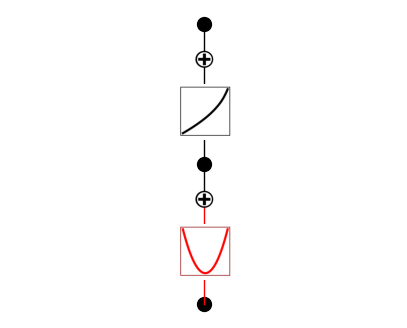

In [106]:
model2.plot()

In [107]:
model2.suggest_symbolic(1,0,0)

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      x^0.5    0.999957 -14.193489           2                2   -1.238698
1       sqrt    0.999957 -14.193489           2                2   -1.238698
2        log    0.999722 -11.763921           2                2   -0.752784
3    1/x^0.5    0.999485 -10.894391           2                2   -0.578878
4  1/sqrt(x)    0.999485 -10.894391           2                2   -0.578878


('x^0.5',
 (<function kan.utils.<lambda>(x)>,
  <function kan.utils.<lambda>(x)>,
  2,
  <function kan.utils.<lambda>(x, y_th)>),
 0.9999566254728288,
 2)

In [72]:
from kan.utils import fit_params
fit_params(x**2, y, lambda x: x**(1/2))

Best value at boundary.
r2 is 0.9989821969546337


(tensor([-9.8000,  9.8868, -0.3482,  1.2049]), tensor(0.9990))

In [74]:
model2.auto_symbolic()

skipping (0,0,0) since already symbolic
fixing (1,0,0) with x^0.5, r2=0.9999494098870415, c=2
saving model version 0.4


In [79]:
from kan.utils import ex_round
ex_round(model2.symbolic_formula()[0][0], 2)

1.19 - 1.08*sqrt(1 - 1.0*x_1**2)